# SpatialStegoDectect

**This work is outlined in two main parts:**

A. The main part (the proposed model and the related functions)

B. Working with BOSSBase1.01

**Our dataset images are from the BOSSBASE1.01 (Break Our Steganographic System version 1.01): http://agents.fel.cvut.cz/boss/index.php?mode=VIEW&tmpl=materials


# A. The main part

Mounting the google drive

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries

In [123]:
!pip install tensorflow-addons==0.16.1

import os
import random
import glob
import numpy as np
import pandas as pd
from scipy import ndimage, signal
from skimage.util.shape import view_as_blocks
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from time import time
import datetime

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.initializers import Constant, RandomNormal, glorot_normal
from keras import optimizers, regularizers
from keras.layers import Activation, Conv2D, LeakyReLU, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Concatenate, Reshape, Dense
from keras.models import Model, Sequential

import tensorflow as tf
from tensorflow.keras.layers import Lambda, Layer, ReLU, SpatialDropout2D
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, plot_model

import tensorflow_addons as tfa
from tensorflow_addons.layers.adaptive_pooling import AdaptiveAveragePooling2D
import tensorflow_addons.utils.keras_utils as conv_utils

import ntpath

import keras.backend as K
from keras.layers import concatenate, Reshape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


30 SRM filters for preprocessing and the activation function

In [124]:
# 30 SRM FILTERS
srm_weights = np.load('/content/drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/SRM_file/SRM.npy') 
biasSRM=np.ones(30)
print (srm_weights.shape)
# ACTIVATION FUNCTION
T3 =3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

(5, 5, 1, 30)


#Architecture

If you have 'n' inputs based on their different sizes, you can modify the number of inputs to 'n' (see the first line [def SpatialStegoDectect(img_size=256, num_inputs=1):]and change num_inputs to 'n')

In [125]:
def SpatialStegoDectect(img_size=256, num_inputs=1):
    tf.keras.backend.clear_session()

    # Inputs
    inputs = []
    for i in range(num_inputs):
        inputs.append(Input(shape=(img_size, img_size, 1), name=f"input_{i+1}"))

    # Reshape inputs to have the same spatial dimensions
    reshapes = []
    for i in range(num_inputs):
        pool_size = img_size // (2 ** i)
        reshape = AveragePooling2D(pool_size=(pool_size, pool_size))(inputs[i])
        reshapes.append(reshape)

    # Block 1
    layers = tf.keras.layers.Conv2D(30, (5, 5), strides=(1, 1), padding='valid')(inputs[0])
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 2
    layers = tf.keras.layers.DepthwiseConv2D((1, 1), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.SeparableConv2D(30, (3, 3), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 3
    layers = tf.keras.layers.DepthwiseConv2D((1, 1), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.SeparableConv2D(30, (3, 3), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 4
    layers = tf.keras.layers.Conv2D(60, (3, 3), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(layers)

    # Block 5
    layers = tf.keras.layers.Conv2D(60, (3, 3), strides=(1, 1), padding='valid')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(layers)

    # Block 6
    layers = tf.keras.layers.DepthwiseConv2D((1, 1), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.SeparableConv2D(384, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 7
    layers = tf.keras.layers.DepthwiseConv2D((1, 1), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)
    layers = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 8
    layers = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 9
    layers = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 10
    layers = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(layers)

    # Block 11
    layers = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 12
    layers = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 13 (Multi-scale pooling)
    pool_1 = tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(layers)
    pool_2 = tf.keras.layers.AveragePooling2D((4, 4), strides=(4, 4))(layers)
    pool_3 = tf.keras.layers.AveragePooling2D((8, 8), strides=(8, 8))(layers)
    pool_4 = tf.keras.layers.AveragePooling2D((16, 16), strides=(16, 16))(layers)

    # Adjust the shapes of the pooling layers
    pool_1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(pool_1)
    pool_2 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(pool_2)
    pool_3 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(pool_3)
    pool_4 = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(pool_4)

    # Concatenate for multi-scale pooling layers
    reshape_outputs = [Reshape((-1,))(reshape) for reshape in reshapes]
    layers = concatenate(reshape_outputs)

    # Block 14
    layers = tf.keras.layers.Dense(4096)(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 15
    layers = tf.keras.layers.Dense(4096)(layers)
    layers = tf.keras.layers.LeakyReLU()(layers)

    # Block 16
    layers = tf.keras.layers.Dense(2, activation='softmax', name="output_1")(layers)

    # Model generation
    model = Model(inputs=inputs, outputs=layers)

    # Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print("SpatialStegoDetect model generated")

    return model





Functions for the architecture

In [126]:

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, threshold=0, model_name=""):
    start_time = tm.time()
    log_dir="/content/drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/logs/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    history=model.fit(X_train, y_train, epochs=epochs, 
                        callbacks=[tensorboard,checkpoint], 
                        batch_size=batch_size,validation_data=(X_valid, y_valid),initial_epoch=initial_epoch)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir="/content/drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/Results/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,2)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy (in %)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss (in %)')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [127]:
def Final_Results_Test(model,Trained_Models):
    B_accuracy = 0 #B --> Best
    for filename in os.listdir(Trained_Models):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(Trained_Models+'/'+filename)
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n') 
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [128]:
from tqdm import tqdm
def plot_train_valid(model,Trained_Models,model_name):
    acc_train=[]
    acc_valid=[]
    loss_train=[]
    loss_valid=[]
    for filename in tqdm(os.listdir(Trained_Models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(Trained_Models+'/'+filename)
            loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
            acc_train.append(accuracy)
            loss_train.append(loss)
            loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
            acc_valid.append(accuracy)
            loss_valid.append(loss)

    results_dir="/content/drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/Results/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.subplot(1,1,1)
        #Plot training & validation accuracy values
        plt.plot(acc_train)
        plt.plot(acc_valid)
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy in %')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_SpatialStegoDectect_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.subplot(1,1,1)
        #Plot training & validation loss values
        plt.plot(loss_train)
        plt.plot(loss_valid)
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss in %')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_SpatialStegoDectect_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 10))
        plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
    return results

ROC curves Plotting

In [129]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_curve(gt, pred, target_names,model_name):
    labels=[]
    for i in range(len(target_names)):
        
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = model_name+target_names[i] + " AUC: %.3f " % auc_roc
        labels.append(label)
        xlabel = "FPR"
        ylabel = "TPR"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(5, 5))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1, 1),
                  fancybox=True, ncol=1)
      
    return [a,b],labels
labels = ["Cover","Stego"]

# B. Working with BOSSbase 1.01

In [130]:
CH01 = 'drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber'
#Dataset
EPOCHS=10
CH01_WOW1 = "/Numpy_files/"

#Train
X_train = np.load(CH01+CH01_WOW1+'X_training.npy')
y_train = np.load(CH01+CH01_WOW1+'y_training.npy')
#Valid
X_valid = np.load(CH01+CH01_WOW1+'X_validating.npy')
y_valid = np.load(CH01+CH01_WOW1+'y_validating.npy')
#Test
X_test = np.load(CH01+CH01_WOW1+'X_testing.npy')
y_test = np.load(CH01+CH01_WOW1+'y_testing.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(16, 256, 256)
(16, 2)
(12, 256, 256)
(12, 2)
(8, 256, 256)
(8, 2)


CNN name and algorithm 

In [131]:
base_name="WOW"
m_name="SpatialStegoDectect"

Training

SpatialStegoDetect model generated
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 2.1365 - accuracy: 0.5000 - val_loss: 26.2736 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 23.3989 - accuracy: 0.5000 - val_loss: 28.7996 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 577ms/step - loss: 25.6486 - accuracy: 0.5000 - val_loss: 34.8969 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 607ms/step - loss: 32.7312 - accuracy: 0.5000 - val_loss: 7.1978 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 542ms/step - loss: 6.4124 - accuracy: 0.5000 - val_loss: 5.2126 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 1s 676ms/step - loss: 5.0073 - accuracy: 0.5000 - val_loss: 3.6953 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 637ms/step - loss: 3.6671 - accuracy: 0.5000 - val_loss: 5.3134 - val_ac

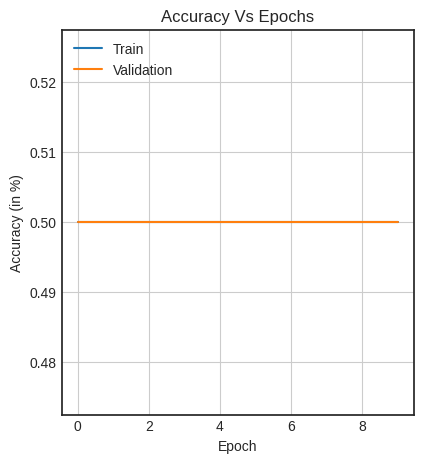

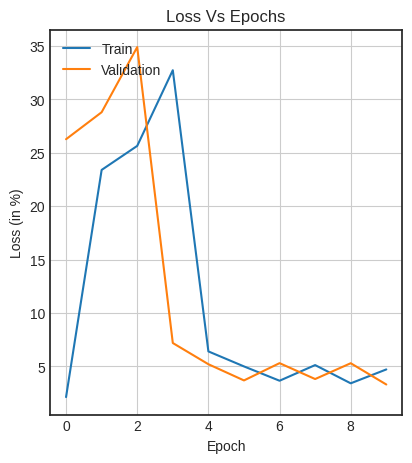

Time Model_SpatialStegoDectect_WOW = 12.11307978630066 [seconds]


In [132]:
model= SpatialStegoDectect() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=10, model_name=name)

Test

In [133]:
model= SpatialStegoDectect() 
PATH_trained_models = 'drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/logs/Model_SpatialStegoDectect_WOW_1685434043.4932103'
Final_Results_Test(SpatialStegoDectect(), PATH_trained_models)

SpatialStegoDetect model generated
SpatialStegoDetect model generated
saved-model-01-0.50.hdf5
Loss=28.0114 y Accuracy=0.5000

saved-model-02-0.50.hdf5
Loss=30.7045 y Accuracy=0.5000

saved-model-03-0.50.hdf5
Loss=36.2043 y Accuracy=0.5000

saved-model-04-0.50.hdf5
Loss=7.6667 y Accuracy=0.5000

saved-model-05-0.50.hdf5
Loss=5.3330 y Accuracy=0.5000

saved-model-06-0.50.hdf5
Loss=3.7052 y Accuracy=0.5000

saved-model-07-0.50.hdf5
Loss=5.4195 y Accuracy=0.5000

saved-model-08-0.50.hdf5
Loss=4.0649 y Accuracy=0.5000

saved-model-09-0.50.hdf5
Loss=5.6542 y Accuracy=0.5000

saved-model-10-0.50.hdf5
Loss=3.5251 y Accuracy=0.5000



Best
saved-model-01-0.50.hdf5
Loss=28.0114 y Accuracy=0.5000



ROC curves

SpatialStegoDetect model generated


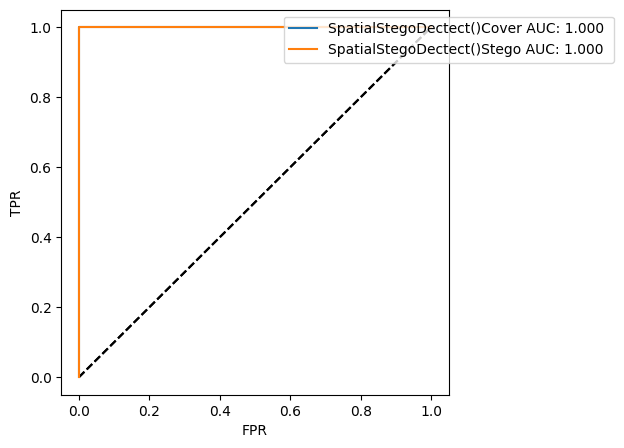

In [136]:
model= SpatialStegoDectect() 
model.load_weights("drive/My Drive/SIMPA_CYBERSECURITY/Final_SIMPA_Cyber/logs/Model_SpatialStegoDectect_WOW_1685434043.4932103/saved-model-07-0.50.hdf5") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="SpatialStegoDectect()"
curve1,labels1=get_curve(y_test, predictions, labels,model_name) 

# For the full implementation of our paper in Cybersecurity paper (Given in Reference [16] of our paper to SIMPA) you can refer to "https://drive.google.com/drive/folders/1jkr01hjH3YFQcQNociiAxnp1Zgn6jYJX?usp=sharing"

# ***End***
